In [1]:
import warnings

import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
import matplotlib.pyplot as plt 

from scipy import stats
from patsy import dmatrix
import statsmodels.formula.api as smf

import sklearn.preprocessing as preprocessing

warnings.simplefilter(action="ignore", category=FutureWarning)
%config Inline.figure_format = 'retina'
az.style.use('arviz-darkgrid')
az.rcParams["stats.hdi_prob"] = 0.89 # set default credible interval used by arviz
np.random.seed(0)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sppnames = ["afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster", "sapiens"]
brainvolcc = [438, 452, 612, 521, 752, 871, 1350]
masskg = [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]
d = pd.DataFrame({"species": sppnames, "brain": brainvolcc, "mass": masskg})
d

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


We standardize body mass - give it mean zero and standard deviation one -- and rescale the outcome, brain volume, so that the largest observed value is 1. Why not standardize brain volume as well? Because we want to preserve zero as a reference point: No brain at all. You can't have negative brain.

In [3]:
d['mass_std'] = preprocessing.scale(d.mass)
d['brain_std'] = d.brain / np.max(d.brain)

The first linear model: the average brain volume $b_i$ of species $i$ is a linear function of its body maas $m_i$.

$$ b_i \sim Normal(\mu_i, \sigma) $$
$$ \mu_i = \alpha + \beta*m_i $$
$$ \alpha \sim Normal(0.5, 1) $$
$$ \beta \sim Normal(0, 10) $$
$$ \sigma \sim \text{LogNormal}(0, 1) $$

The prior $\alpha$ is just centered on the mean brain volume (rescaled) in the data. It says that the average species with an average body maas has a brain volume with an 89% credible interval from about -1 to 2. The prior for $\beta$ is very flat and centered on zero.

In [4]:
stats.norm.interval(.89, loc=0.5)

(-1.0981931399228175, 2.0981931399228184)

In [5]:
with pm.Model() as m71:
    a = pm.Normal("a", 0.5, 1)
    b = pm.Normal("b", 0, 10)
    sigma = pm.Lognormal("sigma", 0, 1)
    mu = a + b * d.mass_std
    brain_std = pm.Normal("brain_std", mu=mu, sigma=sigma, observed=d.brain_std)
    m71_trace = pm.sample()
az.summary(m71_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.53,0.10,0.38,0.69,0.0,0.0,2372.21,2228.47,2532.92,1779.44,1.0
b,0.16,0.11,-0.00,0.32,0.0,0.0,2041.71,1527.52,2159.72,1583.72,1.0
sigma,0.26,0.11,0.12,0.40,0.0,0.0,1377.20,1377.20,1462.07,1873.18,1.0


In [6]:
def R2_is_bad(model):
    return 1 - model.resid.var() / d.brain_std.var()

We will consider five more models, each more complex than the last. Each of these models will just be a polynomial of higher degree. A second-degree polynomial that relates body size to brain size is a parabola.

$$ b_i \sim Normal(\mu_i, \sigma) $$
$$ \mu_i = \alpha + \beta_1m_i + \beta_2m_i^2$$
$$ \alpha \sim Normal(0.5, 1) $$
$$ \beta_j \sim Normal(0, 10) \text{ for } j = 1..2$$
$$ \sigma \sim \text{LogNormal}(0, 1) $$

In [7]:
m71 = smf.ols(
    "brain_std ~ mass_std", 
    data=d).fit()
m72 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2)", 
    data=d).fit()
m73 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3)", 
    data=d).fit()
m74 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4)",
    data=d,
).fit()
m75 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5)",
    data=d,
).fit()
m76 = smf.ols(
    "brain_std ~ mass_std + I(mass_std**2) + I(mass_std**3) + I(mass_std**4) + I(mass_std**5) + I(mass_std**6)",
    data=d,
).fit()

<ipython-input-8-5dacc4a2d683>:29: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


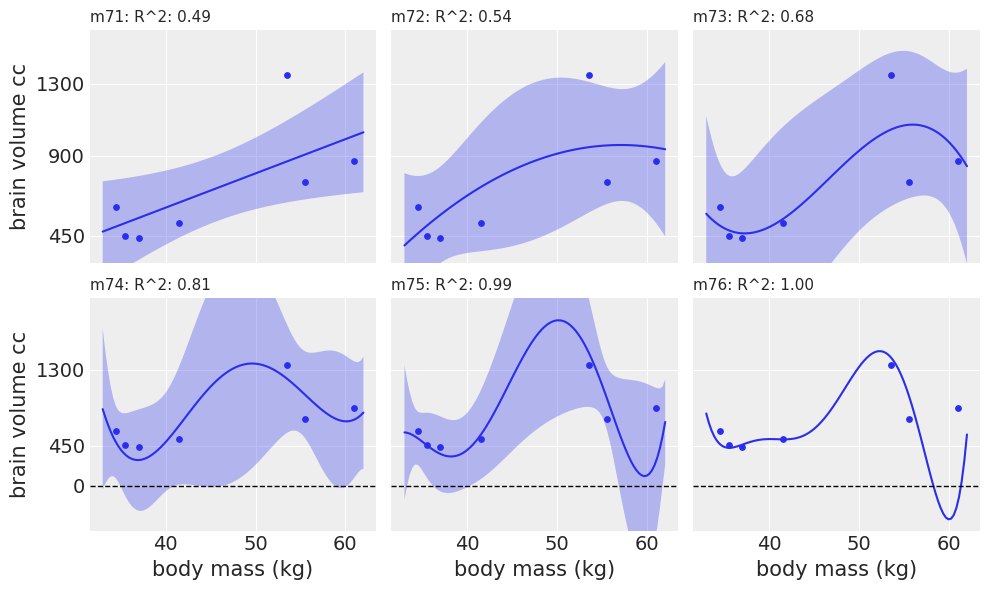

In [8]:
models = [m71, m72, m73, m74, m75, m76]
names = ["m71", "m72", "m73", "m74", "m75", "m76"]
mass_plot = np.linspace(33, 62, 100)
mass_new = (mass_plot - d.mass.mean()) / d.mass.std()
fig, axs = plt.subplots(2, 3, figsize=[10, 6], sharex=True, sharey="row")

for model, name, ax in zip(models, names, axs.flat):
    prediction = model.get_prediction({"mass_std": mass_new})
    pred = prediction.summary_frame(alpha=0.11) * d.brain.max()
    ax.plot(mass_plot, pred["mean"])
    ax.fill_between(mass_plot, pred["mean_ci_lower"], pred["mean_ci_upper"], alpha=0.3)
    ax.scatter(d.mass, d.brain, color="C0", s=15)
    ax.set_title(f"{name}: R^2: {model.rsquared:.2f}", loc="left", fontsize=11)

    if ax.is_first_col():
        ax.set_ylabel("brain volume cc")

    if ax.is_last_row():
        ax.set_xlabel("body mass (kg)")

    if ax.is_last_row():
        ax.set_ylim(-500, 2100)
        ax.axhline(0, ls="dashed", c="k", lw=1)
        ax.set_yticks([0, 450, 1300])        
    else:
        ax.set_ylim(300, 1600)
        ax.set_yticks([450, 900, 1300])

fig.tight_layout()

**Rethinking: Model fitting as compression**. Model fitting can be considered a form of **DATA COMPRESSION**. Parameters summarize relationships amont the data. These summaries compress the data into a simpler form, although with loss of information ("lossy" compression) about the sample. The parameters can then be used to generate new data, effectively decompressing the data. When a model has a parameter to correspond to each datum, then there is actually  no compression. The model just encodes the raw data in a different form, using parameters instead. As a result, we learn nothing about the data from such model. Learning about the data requires using a simpler model that achieves some compression, but not too much. This view of model selection is often known as **MINIMUM DESCRIPTION LENGTH (MDL)**.

### Entropy and accuracy

How do we navigate between the hydra of overfitting and the vortex of underfitting? Whether you end up using regularization or information criteria, the first thing you must do is pick a criterion of model performance. Steps ahead:

1) Establish a measurement scale for distance from perfect accuracy. (information theory, as it will provide a natural measurement scale for the distance between two probability distributions).

2) Establish a deviance as an approximation of relative distance from perfect accuracy. The basic insight is to ask: *How much is our uncertainty reduced by learning an outcome?*

The defintion of *information* in this context: The reduction in uncertainty when we learn an outcome.
To use this definition, what we need is a principled way to quantify the uncertainty inherent in a probability distribution. Some properties a measure of uncertainty should possess

1) The measure of uncertainty should be continuous

2) The measure of uncertainty should increase as the number of possible events increases. 

3) The measure of uncertainty should be additive.

There is only one function that satisfies these desiderata. This function is usually known as **INFORMATION ENTROPY**, and has a surprisingly simple definition. If there are n different possible events and each event $i$ has probability $p_i$, and we call the list of probabilities $p$, then the unique measure of uncertainty we seek is 

$$ H(p) = -Elog(p_i) = - \sum_{i=1}^{n}p_ilog(p_i) $$

In plainer words: *The uncertainty contained in a probability distribution is the average log-probability of an event*

**From entropy to accuracy**: Divergence the additional uncertainty induced by using probabilities from one distribution to describe another distribution. This is often known as Kullback-Leibler divergence or simply K-L divergence.

Example: Suppose the true distribution of events is $p_1 = 0.3, p_2 = 0.7$. If we believe instead that thest events happen with probabilities $q_1 = 0.25, q_2 = 0.75$, how much additional uncertainty have we introduced, as a consequence of using $q = \{q_1, q_2\}$ to approximate $p = \{p_1, p_2\}$

$$ D_{KL}(p, q) = \sum_i p_i (log(p_i) - log(q_i)) = \sum_i p_i log\Big(\frac{p_i}{q_i}\Big) $$

So, in order to calculate DKL, we need to know $p$. However, in practice we are in the process of estimating $p$; We wouldn't be doing statiscal inference, if we already knew $p$. We are only interested in comparing the divergences of different candidates, say $q$ and $r$. Most of $p$ subtracts out. This means we only need to know a model's average log-probability $E(log(q_i))$ and $E(log(r_i))$.

In practice, it is conventional to sum over all the observation $i$, yielding a total score for a model $q$:

$$ S(q) = \sum_i log(q_i) $$

This kind of score is log-probability score, and it is the gold standard way to compare the predictive accuracy of different models. It is an estimate of $Elog(q_i)$, just without the final step of dividing by the number of observations.


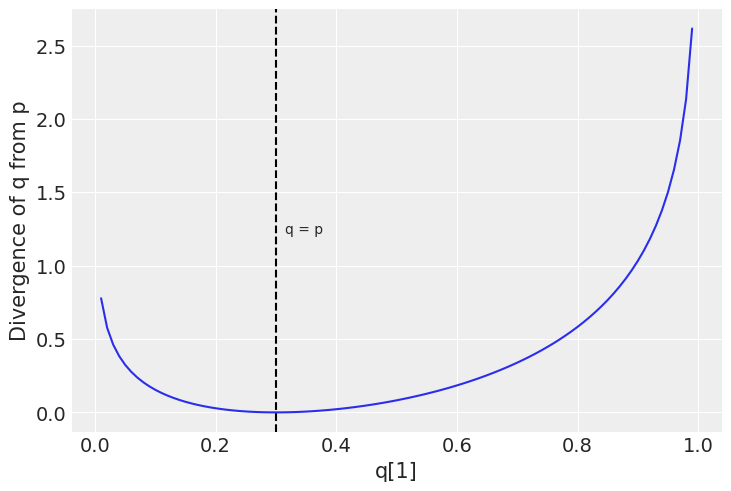

In [9]:
p = np.array([0.3, 0.7])
q = np.arange(0.01, 1, 0.01)
DKL = np.sum(p * np.log(p / np.array([q, 1-q]).T), 1)

plt.plot(q, DKL)
plt.xlabel("q[1]")
plt.ylabel("Divergence of q from p")
plt.axvline(0.3, ls="dashed", color="k")
plt.text(0.315, 1.22, "q = p");

Information divergence of an approximating distribution $q$ from a true distribution $p$. Divergence can only equal zero when $p = q$ (dashed line), otherwise the divergence is positive and grows as $q$ becomes more dissimilar from $p$.

**Overthinking: Computing the lppd**: The Bayesian version of the log-probability score is called the **LOG-POINTWISE-PREDICTIVE-DENSITY**. For some data y and posterior distribution $\Theta$.

$$ \text{lppd}(y, \Theta) = \sum_i log\frac{1}{S}\sum_sp(y_i|\Theta_s) $$

where $S$ is the number of samples and $\Theta_s$ is the $s-th$ set of sampled parameter values in the posterior distribution. **lppd** is the sum of all probabilities of observations, given the posterior distribution, so the larger the value of **lppd** the better the inference is.

In [10]:
from scipy.special import logsumexp
n_samples = 3000

## We calculate the prediction of the model.
intercept, slope = stats.multivariate_normal(m71.params, m71.cov_params()).rvs(n_samples).T
pred = intercept + slope * d.mass_std.values.reshape(-1, 1)
n, ns = pred.shape
sigmas = (np.sum((pred - d.brain_std.values.reshape(-1, 1)) ** 2, 0) / 7) ** 0.5
ll = np.zeros((n, ns))
for s in range(ns):
    logprob = stats.norm.logpdf(d.brain_std, pred[:, s], sigmas[s])
    ll[:, s] = logprob

lppd = np.zeros(n)
for i in range(n):
    lppd[i] = logsumexp(ll[i]) - np.log(ns)
lppd

array([ 0.61866196,  0.65761765,  0.55820921,  0.62547002,  0.46909862,
        0.43760799, -0.82899301])

In [11]:
def lppd(model, n_samples=1e4):
    """ Calculate lppd of a model """
    n_samples = int(n_samples)
    pars = stats.multivariate_normal(model.params, model.cov_params()).rvs(n_samples).T
    dmat = dmatrix(
        model.model.data.design_info, d, return_type="dataframe"
    ).values
    pred = dmat.dot(pars)
    n, ns = pred.shape
    sigmas = (np.sum((pred - d.brain_std.values.reshape(-1, 1)) ** 2, 0) / 7) ** 0.5
    ll = np.zeros((n, ns))
    for s in range(ns):
        logprob = stats.norm.logpdf(d.brain_std, pred[:, s], sigmas[s])
        ll[:, s] = logprob

    lppd = np.zeros(n)
    for i in range(n):
        lppd[i] = logsumexp(ll[i]) - np.log(ns)
    return lppd

In [12]:
lppds = np.array(list(map(lppd, models[:-1], [1000]*len(models[:-1]))))
lppds.sum(1)

array([ 2.48552615,  2.34021834,  2.86785665,  3.54391366, 11.0704396 ])

In [13]:
def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100):
    """Simulation train/test data"""
    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    Rho = np.diag(np.ones(n_dim))
    Rho[0,1:3:1] = rho
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]

    X_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    X_test = stats.multivariate_normal.rvs(cov=Rho, size=N)

    mm_train = np.ones((N, 1))

    with pm.Model() as m_sim:
        vec_V = pm.MvNormal("vec_V", mu=0, cov=b_sigma * np.eye(n_dim), 
                             shape=(1, n_dim), testval=np.random.randn(1, n_dim)*0.01)
        mu = pm.Deterministic("mu", 0 + pm.math.dot(X_train, vec_V.T))
        y = pm.Normal("y", mu=mu, sd=1, observed=X_train[:, 0])

    with m_sim:
        trace_m_sim = pm.sample(return_inferencedata=True)

    vec = az.summary(trace_m_sim)["mean"][:n_dim]
    vec = np.array([i for i in vec]).reshape(n_dim, -1)
    dev_train = -2 * sum(stats.norm.logpdf(X_train, loc=np.matmul(X_train, vec), scale=1))
    
    mm_test = np.ones((N, 1))
    mm_test = np.concatenate([mm_test, X_test[:, 1 : k+1]], axis=1)
    dev_test = -2 * sum(stats.norm.logpdf(X_test, loc=np.matmul(X_test, vec), scale=1))

    return np.mean(dev_train), np.mean(dev_test)

In [14]:
n = 100
tries = 10
param = 6
r = np.zeros(shape=(param - 1, 4))

train = []
test = []

for j in range(2, param + 1):
    print(j)
    for i in range(1, tries + 1):
        tr, te = sim_train_test(N=n, k=param)
        train.append(tr), test.append(te)
    r[j - 2, :] = (
        np.mean(train),
        np.std(train, ddof=1),
        np.mean(test),
        np.std(test, ddof=1),
    )

2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


3


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


4


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


6


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


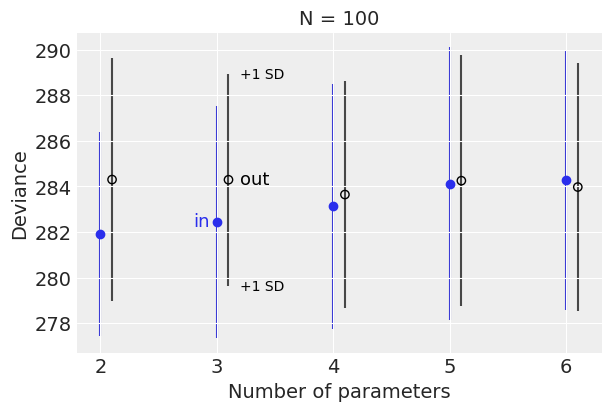

In [15]:
num_param = np.arange(2, param + 1)

plt.figure(figsize=(6, 4))
plt.scatter(num_param, r[:, 0], color='C0')
plt.xticks(num_param)

for j in range(param - 1):
    plt.vlines(num_param[j], r[j,0] - r[j, 1], r[j,0] + r[j,1], color='mediumblue', 
               zorder=-1, alpha=0.80)

plt.scatter(num_param + 0.1, r[:, 2], facecolors='none', edgecolors='k')

for j in range(param - 1):
    plt.vlines(num_param[j] + 0.1, r[j,2] - r[j, 3], r[j,2] + r[j,3], color='k', 
               zorder=-2, alpha=0.70)    

dist = 0.20
plt.text(num_param[1] - dist, r[1, 0] - dist, 'in', color='C0', fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] - dist, 'out', color='k', fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] + r[1,3] - dist, '+1 SD', color='k', fontsize=10)
plt.text(num_param[1] + dist, r[1, 2] - r[1,3] - dist, '+1 SD', color='k', fontsize=10)
plt.xlabel('Number of parameters', fontsize=14)
plt.ylabel('Deviance', fontsize=14)
plt.title(f'N = {n}', fontsize=14)
plt.show()

These uncertainties are a log larger than in the book... MCMC vs OLS?

## Golem Taming: Regularization

The root of overfitting is a model's tendency to get overexcited by the training sample. When the priors are flat or nearly flat, the machin interprets this to mean that every parameter value is equally plausible. As a result, the model returns a posterior that encodes as much of the training sample -- as represented by the likelihood function -- as possible. One way to prevent a model from getting too excited by the training sample is to use a skeptical prior. By "skeptical", I mean a prior that slows the rate of learning from the sample.

**Rethinking: Ridge regression**. Linear models in which the slope parameters use Gaussian priors centered at zero, are sometimes known as **RIDGE REGRESSION**. Ridge regression typically takes as input a precision $\lambda$ that essentially describes the narrowness of the prior. $\lambda > 0$ results in less overfitting. However, just as with the Bayesian version, if $\lambda$ is too large, we risk underfittin. 

In [16]:
stats.norm.interval(.95)

(-1.959963984540054, 1.959963984540054)

## Prediction Predictive Accuracy

One way to navigate overfitting and underfitting: Evaluate our models out-of-sample. There are 2 families of strategies: **CROSS-VALIDATION** and **INFORMATION CRITERIA**.

Cross Validation

* Leave-one-out cross validation (LOOCV)
* Pareto-smoothed importance sampling cross-validation (PSI)

Information Criteria

* Akaike Information Criterion (AIC)
* Deviance Information Criterion (DIC)
* Widely applicable information criterion (WAIC) 

How do we compute WAIC? WE can compute both directly from samples from the posterior distribution. WAIC is just the log-posterior-predictive-density that we calculated plus a penalty proportional to the variance in the posterior predictions:

$$ \text{WAIC}(y, \Theta) = -2\big(\text{lppd} - \sum_i\text{var}_\theta \text{log}p(y_i|\theta)\big) $$

The penalty term means "compute the variance in log-probabilities for each observation $i$, and then sum up these variances to get the total penalty.

**Overthinking: WAIC Calculation**: to see how WAIC calculations actually work, we consider a simple linear regression below.

In [17]:
import os
data_dir = '/home/telescreen/Workspace/fun/pymc-devs-resources/Rethinking_2/Data/'
cars = pd.read_csv(os.path.join(data_dir, "cars.csv"))
cars.describe()

,Unnamed: 0,speed,dist
count,50.00000,50.000000,50.000000
mean,25.50000,15.400000,42.980000
std,14.57738,5.287644,25.769377
min,1.00000,4.000000,2.000000
25%,13.25000,12.000000,26.000000
50%,25.50000,15.000000,36.000000
75%,37.75000,19.000000,56.000000
max,50.00000,25.000000,120.000000


In [32]:
with pm.Model() as m:
    a = pm.Normal("a", 0, 100)
    b = pm.Normal("b", 0, 10)
    mu = a + b*cars.speed
    sigma = pm.Exponential("sigma", 1)
    dist = pm.Normal("dist", mu=mu, sigma=sigma, observed=cars.dist)
    m = pm.sample(5000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 22 seconds.


In [33]:
n_samples = 1000
n_cases = cars.shape[0]
logprob = np.zeros((n_cases, n_samples))
for s in range(n_samples):
    mu = m['a'][s] + m['b'][s] * cars.speed
    dist = stats.norm.logpdf(cars.dist, loc=mu, scale=m['sigma'][s])
    logprob[:, s] = dist

`logprob` is the 50x1000 matrix of log-likelihoods, with observations in rows and samples in columns. To calculate `lppd`, the Bayesian deviance, we average the samples in each row, take the log, and add all the logs together. We need to do all averaging on the log scale using the `logsumexp` function.

In [34]:
lppd = logsumexp(logprob, 1) - np.log(n_samples)
pWAIC = np.var(logprob, 1)
-2*(sum(lppd) - sum(pWAIC))

421.410420690974

In [36]:
waic_vec = -2*(lppd - pWAIC)
np.sqrt(n_cases * np.var(waic_vec))

16.18544858182802

In [50]:
az.waic(m, scale="deviance")

/home/telescreen/Softwares/miniconda3/envs/data/lib/python3.8/site-packages/arviz/stats/stats.py:1425: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 20000 by 50 log-likelihood matrix

              Estimate       SE
deviance_waic   421.37    16.17
p_waic            4.07        -

There has been a warning during the calculation. Please check the results.

## Model Comparison

Regularizing priors and CV/PSIS/WAIC are complementary. Regularization reduces overfitting, and predictive criteria measure overfitting.
How do we use regularizing priors and CV/PSIS/WAIC?

A very common use of cross-validation and information criteria is to perform Model selection, by choosing the model with the lowest criterion value and then discarding the others. We should never do this because: 

1. This kind of selection procedure discards the information about relative model accuracy contained in the differeces among the CV/PSIS/WAIC values.
2. We might care about causal inference. Maximizing expected predictive accuracy is not the same as inferring causation.

2 examples of analysis to demonstrate the above 2 points

#### 1. Model mis-selection

In [37]:
# Number of plants
N = 100
h0 = np.random.normal(10, 2, N)
treatment = np.repeat([0, 1], N/2)
fungus = np.random.binomial(1, 0.5 - treatment*0.4, N)
h1 = h0 + np.random.normal(5 - 3*fungus, size=N)
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})
d.head()

,h0,h1,treatment,fungus
0,9.002046,10.393414,0,1
1,11.566241,15.825500,0,0
2,11.077446,13.927980,0,1
3,11.066635,16.771899,0,0
4,9.745991,10.411654,0,1


In [46]:
with pm.Model() as m66:
    p = pm.Lognormal("p", 0, 0.25)
    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)
    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)
    m66_trace = pm.sample(return_inferencedata=True)

with pm.Model() as m67:
    a = pm.Lognormal("a", 0, 0.25)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)    
    p = a + bt*d.treatment + bf*d.fungus
    mu = p * d.h0
    sigma = pm.Exponential("sigma", 1)
    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)    
    m67_trace = pm.sample(return_inferencedata=True)
    
with pm.Model() as m68:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    p = a + bt * d.treatment
    mu = pm.Deterministic("mu", p * d.h0)
    sigma = pm.Exponential("sigma", 1)
    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1)
    m68_trace = pm.sample(return_inferencedata=True)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bf, bt, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bt, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [47]:
az.waic(m67_trace, m67, scale='deviance')

/home/telescreen/Softwares/miniconda3/envs/data/lib/python3.8/site-packages/arviz/stats/stats.py:1425: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 by 100 log-likelihood matrix

              Estimate       SE
deviance_waic   344.88    15.38
p_waic            3.87        -

There has been a warning during the calculation. Please check the results.

In [48]:
compare_df = az.compare({"m66": m66_trace, "m67": m67_trace, "m68": m68_trace}, 
                        method="pseudo-BMA", ic="waic", scale="deviance")
compare_df

/home/telescreen/Softwares/miniconda3/envs/data/lib/python3.8/site-packages/arviz/stats/stats.py:1425: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m67,0,344.882,3.8663,0,1,15.3816,0,True,deviance
m68,1,415.31,2.75664,70.4286,5.08897e-16,13.5021,12.7365,False,deviance
m66,2,420.855,1.6481,75.9732,3.1815e-17,11.4369,13.4157,False,deviance


In [52]:
waic67 = az.waic(m67_trace, pointwise=True, scale="deviance")
waic68 = az.waic(m68_trace, pointwise=True, scale="deviance")

/home/telescreen/Softwares/miniconda3/envs/data/lib/python3.8/site-packages/arviz/stats/stats.py:1425: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [55]:
n = len(waic67.waic_i)
np.sqrt(n*np.var(waic67.waic_i - waic68.waic_i))

<xarray.DataArray 'waic_i' ()>
array(12.73649567)

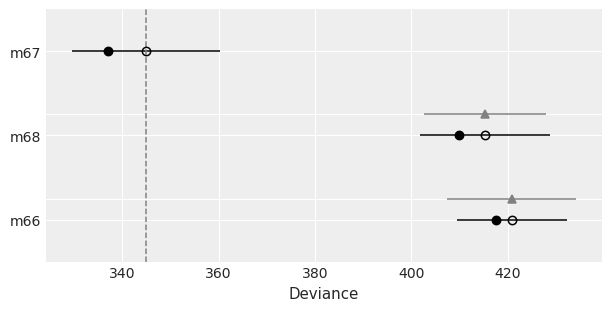

In [57]:
az.plot_compare(compare_df);

It means that WAIC cannot be used to infer causation. We know, because we simulated these data, that the treatment matters. But because fungus mediates treatement, it is on a pipe between treatment and the outcome - once we condition on fungus, treatment provides no additional information.

#### 2. outliers and other illusions

Outliners (individual points) tend to be very influential in ordinary regression models.

In [62]:
data_dir = '/home/telescreen/Workspace/fun/pymc-devs-resources/Rethinking_2/Data/'
data = pd.read_csv(os.path.join(data_dir, 'WaffleDivorce.csv'), sep=';')
data['A'] = preprocessing.scale(data.MedianAgeMarriage)
data['D'] = preprocessing.scale(data.Divorce)
data['M'] = preprocessing.scale(data.Marriage)

with pm.Model() as m51:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = a + bA * data.A
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=data.D)
    m51_trace = pm.sample(return_inferencedata=True)
    
with pm.Model() as m52:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = a + bM * data.M
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=data.D)
    m52_trace = pm.sample(return_inferencedata=True)
    
with pm.Model() as m53:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = a + bA * data.A + bM * data.M
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=data.D)
    m53_trace = pm.sample(return_inferencedata=True)
    
az.compare({"m51": m51_trace, "m52": m52_trace, "m53": m53_trace}, scale="deviance")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m51,0,127.039,3.80423,0,0.637684,12.6967,0,False,deviance
m53,1,128.667,4.76006,1.62816,0.283071,9.66872,0.771344,False,deviance
m52,2,140.775,3.19396,13.7355,0.0792444,12.4978,9.3656,False,deviance
